In [13]:
import numpy as np; import pandas as pd; import pyodbc; import datetime; import sklearn; import os; import math
from sklearn import feature_selection, linear_model, grid_search, cross_validation, metrics, ensemble, learning_curve 
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from datetime import datetime
from sklearn.cluster import KMeans
import pickle
import seaborn as sns
import xgboost as xgb
from sklearn.feature_selection import chi2, f_classif, SelectKBest
from sklearn.preprocessing import StandardScaler
%pylab inline 
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from IPython.core.display import display,HTML
display(HTML("<style>.container{width:90% !important;}</style>"))

conn = pyodbc.connect(r'DRIVER={SQL Server Native Client 11.0};'r'SERVER=WIN-5G5AUOCEJPK;'r'DATABASE=Gold585;'r'Trusted_Connection=yes;')


Populating the interactive namespace from numpy and matplotlib


In [14]:
#Отбираем ПОСЛЕДНИЕ залоговые билеты со статусом Новый залог за последний год
sql_query = "SELECT  \
      [PartnerID] \
      ,[Age] \
      ,[SEX] \
      ,[CityID] \
      ,LifeTimeM*30/QntPurchaseCode AvgDneyPrihodov \
      ,[LifeTimeM] + DATEDIFF(Month, PurchaseDateTime, GetDate()) [LifeTimeM] \
      ,[QntPurchaseCode] \
      ,[SumQuantity] \
      ,[SUMisPartnerPromotionID] \
      ,[PercentisPartnerPromotionID] \
      ,[AVGisPartnerPromotionID] \
      ,[SUMisCrossPromo] \
      ,[PercentisCrossPromo] \
      ,[AVGisCrossPromo] \
      ,[PercentSMS_new] \
      ,[AVGPercentinSMS] \
      ,[PercentMonth1] \
      ,[PercentMonth2] \
      ,[PercentMonth3] \
      ,[PercentMonth4] \
      ,[PercentMonth5] \
      ,[PercentMonth6] \
      ,[PercentMonth7] \
      ,[PercentMonth8] \
      ,[PercentMonth9] \
      ,[PercentMonth10] \
      ,[PercentMonth11] \
      ,[PercentMonth12] \
      ,[PercentNY] \
      ,[PercentDR] \
      ,[PercentVD] \
      ,[Percent8M] \
      ,[SUMPrice] \
      ,[AVGPrice] \
      ,[SumSumma] \
      ,[AVGSumma] \
      ,[SumSummaDiscount] \
      ,[AvgSummaDiscount] \
      ,[AVGProcentSkidki] \
      ,[PercentMen] \
      ,[SumChild] \
      ,[PercentChild] \
      ,[PercentKolco] \
      ,[PercentSERGI] \
      ,[PercentPODVES] \
      ,[PercentFUTLAR] \
      ,[PercentCEP] \
      ,[PercentBRASLET] \
      ,[PercentKOLE] \
      ,[PercentNKNOWN_WEAR] \
      ,[AVGCostPrice] \
      ,[AVGCostMin] \
      ,[AVGCostTag] \
      ,[AVGCostStock] \
      ,[AVGCostRetail] \
      ,[AVGGiftCardPositionID] \
      ,[SumGiftCardPositionID] \
      ,[AVGQntName] \
      ,[PercentExpensive] \
      ,[PercentCheap] \
      ,[PercentPremium] \
      ,[PercentMidle] \
      ,[PercentGold] \
      ,[PercentSilver] \
      ,[PercentNoMetal] \
  FROM [Gold585].[dbo].[RetailCommon] a \
  WHERE partnerID <> 0 and PurchaseDateTime = (Select MAX(PurchaseDateTime) MaxDate From RetailCommon rt where rt.PartnerID = a.PartnerID) \
  and PurchaseDateTime >= CAST('2015-01-01' as DATE) \
  order BY PartnerID, PurchaseDateTime"
data = pd.read_sql(sql_query,conn)

In [15]:
print(data.shape)
print(data[data['QntPurchaseCode']==1].shape[0]/data.shape[0]," - процент от всей базы с 1й покупкой")
print(data[(data['QntPurchaseCode']>1)&(data['QntPurchaseCode']<10)].shape[0]/data.shape[0]," - процент от всей базы от 2х до 9 покупок")
print(data[data['QntPurchaseCode']>=10].shape[0]/data.shape[0]," - процент от всей базы с больше 10-ю покупками")

data.head()

(2521448, 65)
0.620352273772848  - процент от всей базы с 1й покупкой
0.3689146077967898  - процент от всей базы от 2х до 9 покупок
0.010733118430362237  - процент от всей базы с больше 10-ю покупками


,PartnerID,Age,SEX,CityID,AvgDneyPrihodov,LifeTimeM,QntPurchaseCode,SumQuantity,SUMisPartnerPromotionID,PercentisPartnerPromotionID,...,AVGGiftCardPositionID,SumGiftCardPositionID,AVGQntName,PercentExpensive,PercentCheap,PercentPremium,PercentMidle,PercentGold,PercentSilver,PercentNoMetal
0,2,46,0,35,0,32,1,2.0,0,0,...,0,0,1,0.00,0.0,0.0,1.00,1.0,0.000000,0.0
1,4,118,0,92,75,21,8,12.0,0,0,...,0,0,1,0.25,0.5,0.0,0.25,0.0,0.916667,0.0
2,6,30,0,32,0,32,1,2.0,0,0,...,0,0,2,0.00,0.0,0.0,1.00,1.0,0.000000,0.0
3,9,116,0,122,0,32,1,1.0,0,0,...,0,0,1,1.00,0.0,0.0,0.00,1.0,0.000000,0.0
4,10,20,0,105,0,32,1,2.0,0,0,...,0,0,2,0.00,1.0,0.0,0.00,0.0,0.500000,0.5


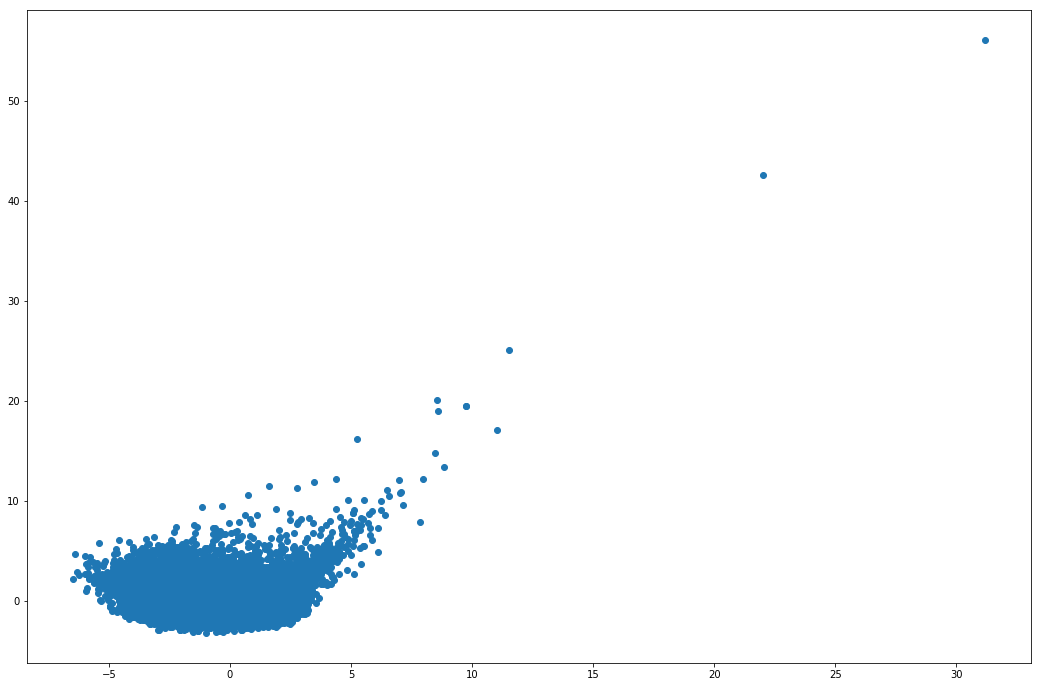

In [30]:
df = data[ (data['QntPurchaseCode']>=10) ].fillna(0)
df.reset_index(drop=True,inplace = True)
target=df.drop(['PartnerID','CityID','SUMisPartnerPromotionID','SumQuantity','SUMisPartnerPromotionID','AVGisPartnerPromotionID','SUMisCrossPromo','AVGisCrossPromo' \
                ,'PercentVD', 'Percent8M', 'PercentDR','PercentNY' ,'AVGPrice', 'PercentMen', 'PercentChild'\
                ,'PercentFUTLAR','PercentKOLE', 'PercentExpensive', 'PercentCheap', 'PercentPremium', 'PercentMidle' \
               ,'PercentMonth1','PercentMonth2','PercentMonth3','PercentMonth4','PercentMonth5','PercentMonth6' \
               ,'PercentMonth7','PercentMonth8','PercentMonth9','PercentMonth10','PercentMonth11','PercentMonth12', 'AVGCostPrice' \
                ,'PercentNKNOWN_WEAR','AVGQntName','AVGGiftCardPositionID','PercentNoMetal' \
               ,'SUMPrice','SumSummaDiscount','AvgSummaDiscount','SumChild','AVGCostMin','AVGCostTag','AVGCostStock','AVGCostRetail','SumGiftCardPositionID'], axis=1)
#target = pd.get_dummies(target, columns = ['CityID'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

Wall time: 7.13 s


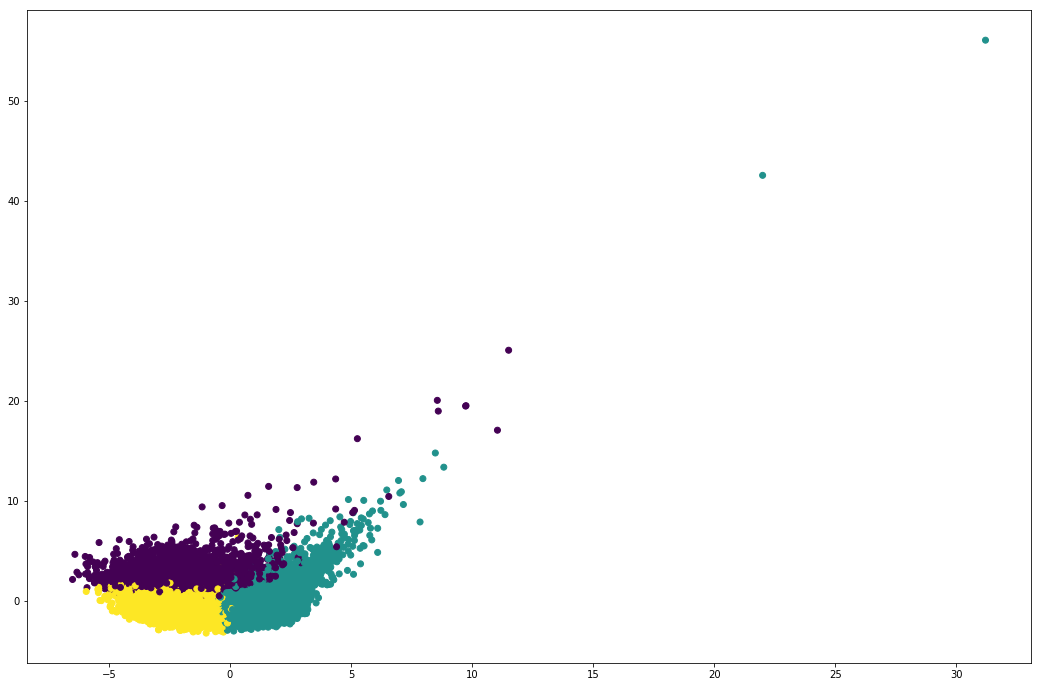

In [31]:
%%time
#Для 1%, где больше 10 покупок
kmeans = KMeans(n_clusters= 3, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [32]:
print(df.shape[0])
print(df[df['labels']==0].shape[0],df[df['labels']==0].shape[0]/df.shape[0])
print(df[df['labels']==1].shape[0],df[df['labels']==1].shape[0]/df.shape[0])
print(df[df['labels']==2].shape[0],df[df['labels']==2].shape[0]/df.shape[0])

27063
2713 0.10024757048368621
15864 0.586187784059417
8486 0.3135646454568969


In [19]:
pd.concat([df[df['labels']==0].describe().T['mean'], \
           df[df['labels']==1].describe().T['mean'], \
           df[df['labels']==2].describe().T['mean'], \
           ],axis=1).to_csv('3-cl.csv')

In [37]:
# у нас в описании 1-й кластер 31%, 2-й 59%, 3-й 10%
label_map = {0: '3.3',
             1: '3.2',
             2: '3.1'}
df['labels'] = df['labels'].map(label_map) 
df[['PartnerID','labels']].to_csv('Segment 3, 3kl.csv')

In [ ]:
#Далее рассмотрим клиентов с 1 покупкой

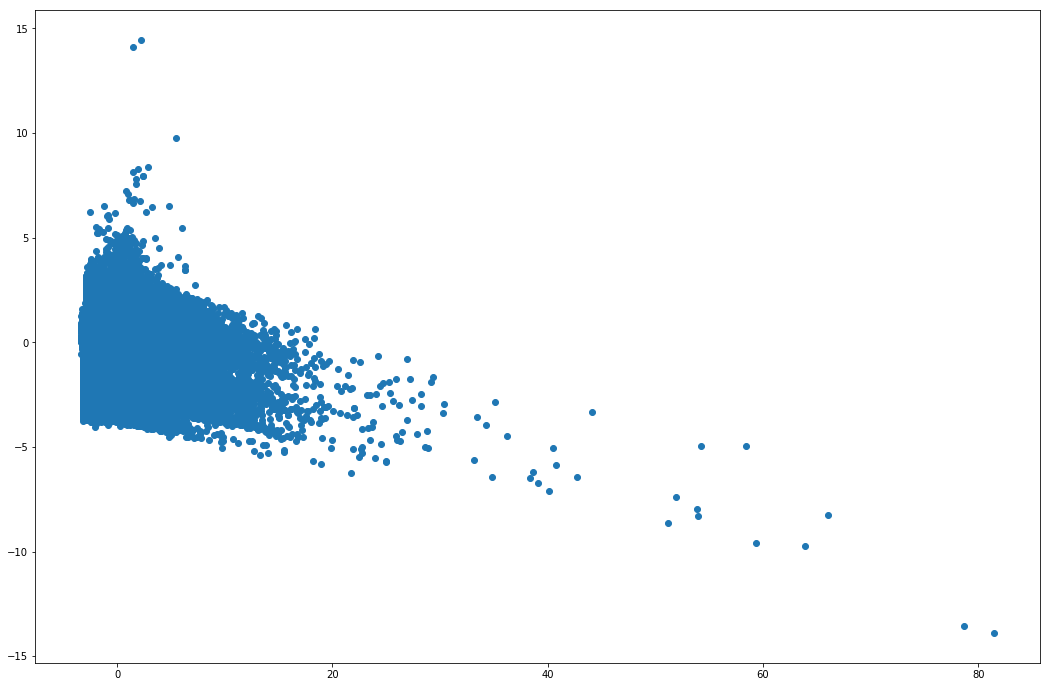

In [33]:
df_1 = data[(data['QntPurchaseCode']==1)].fillna(0)
df_1.reset_index(drop=True,inplace = True)
target=df_1.drop(['PartnerID','CityID','SUMisPartnerPromotionID','SumQuantity','SUMisPartnerPromotionID','AVGisPartnerPromotionID','SUMisCrossPromo','AVGisCrossPromo' \
                ,'PercentVD', 'Percent8M', 'PercentDR','PercentNY' ,'AVGPrice', 'PercentMen', 'PercentChild','PercentSMS_new','AVGPercentinSMS'\
                ,'PercentFUTLAR','PercentKOLE', 'PercentExpensive', 'PercentCheap', 'PercentPremium', 'PercentMidle' \
               ,'PercentMonth1','PercentMonth2','PercentMonth3','PercentMonth4','PercentMonth5','PercentMonth6' \
               ,'PercentMonth7','PercentMonth8','PercentMonth9','PercentMonth10','PercentMonth11','PercentMonth12', 'AVGCostPrice' \
                ,'PercentNKNOWN_WEAR','AVGQntName','AVGGiftCardPositionID','PercentNoMetal' \
               ,'SUMPrice','SumSummaDiscount','AvgSummaDiscount','SumChild','AVGCostMin','AVGCostTag','AVGCostStock','AVGCostRetail','SumGiftCardPositionID'], axis=1)
#target = pd.get_dummies(target, columns = ['CityID'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [34]:
df_1.shape

(1564186, 65)

Wall time: 28.8 s


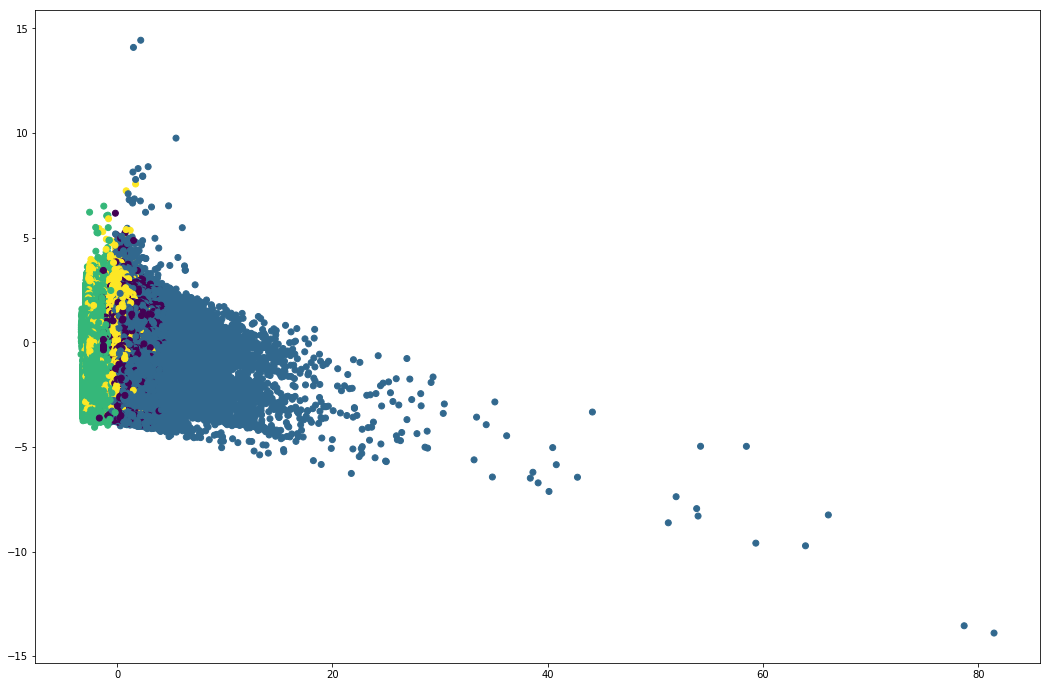

In [35]:
%%time
#Для 63%, где 1 покупка
kmeans = KMeans(n_clusters= 4, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df_1['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [36]:
print(df_1.shape[0])
print(df_1[df_1['labels']==0].shape[0],df_1[df_1['labels']==0].shape[0]/df_1.shape[0])
print(df_1[df_1['labels']==1].shape[0],df_1[df_1['labels']==1].shape[0]/df_1.shape[0])
print(df_1[df_1['labels']==2].shape[0],df_1[df_1['labels']==2].shape[0]/df_1.shape[0])
print(df_1[df_1['labels']==3].shape[0],df_1[df_1['labels']==3].shape[0]/df_1.shape[0])
#print(df_1[df_1['labels']==4].shape[0],df_1[df_1['labels']==4].shape[0]/df_1.shape[0])

1564186
302596 0.19345269680204272
612509 0.39158322603577833
473693 0.3028367470364778
175388 0.11212733012570117


In [25]:
pd.concat([df_1[df_1['labels']==0].describe().T['mean'], \
           df_1[df_1['labels']==1].describe().T['mean'], \
           df_1[df_1['labels']==2].describe().T['mean'], \
           df_1[df_1['labels']==3].describe().T['mean'], \
  #         df[df['labels']==4].describe().T['mean'], \
           ],axis=1).to_csv('1-cl.csv')

In [38]:
# у нас в описании 1-й кластер 19%, 2-й 39%, 3-й 30%, 4-й 11%
label_map = {0: '1.1',
             1: '1.2',
             2: '1.3',
             3: '1.4'}
df_1['labels'] = df_1['labels'].map(label_map) 
df_1[['PartnerID','labels']].to_csv('Segment 1, 4kl.csv')

In [ ]:
# Рассмотрим от 2х до 9 покупок

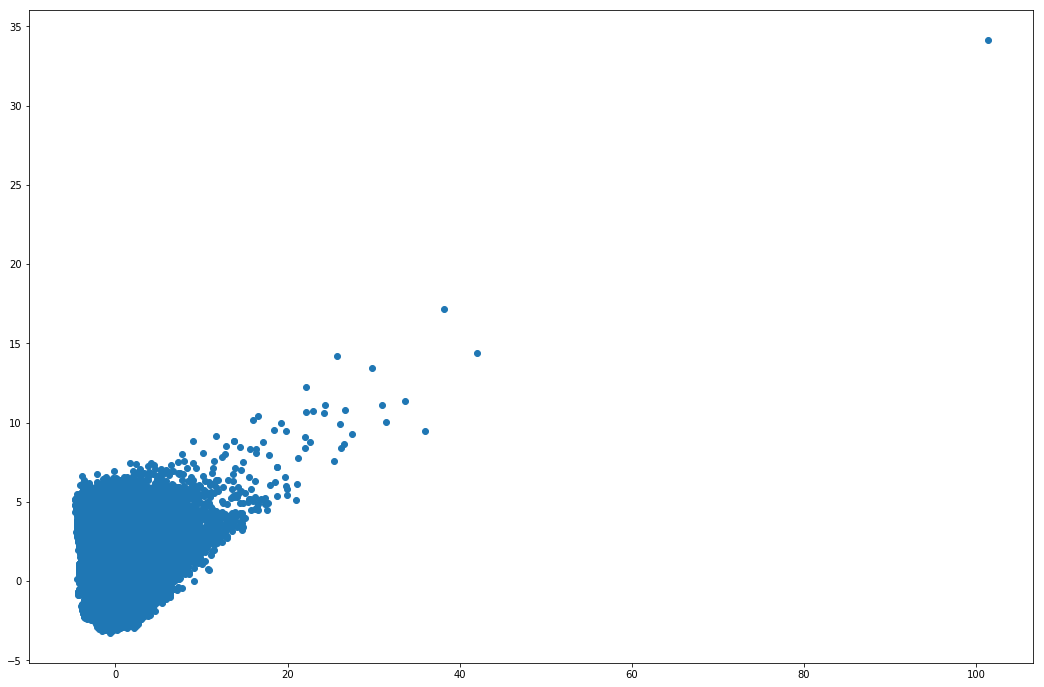

In [39]:
df_2 = data[(data['QntPurchaseCode']>1)&(data['QntPurchaseCode']<10)].fillna(0)
df_2.reset_index(drop=True,inplace = True)
target=df_2.drop(['PartnerID','CityID','SUMisPartnerPromotionID','SumQuantity','SUMisPartnerPromotionID','AVGisPartnerPromotionID','SUMisCrossPromo','AVGisCrossPromo' \
                ,'PercentVD', 'Percent8M', 'PercentDR','PercentNY' ,'AVGPrice', 'PercentMen', 'PercentChild' \
                ,'PercentFUTLAR','PercentKOLE', 'PercentExpensive', 'PercentCheap', 'PercentPremium', 'PercentMidle' \
               ,'PercentMonth1','PercentMonth2','PercentMonth3','PercentMonth4','PercentMonth5','PercentMonth6' \
               ,'PercentMonth7','PercentMonth8','PercentMonth9','PercentMonth10','PercentMonth11','PercentMonth12', 'AVGCostPrice' \
                ,'PercentNKNOWN_WEAR','AVGQntName','AVGGiftCardPositionID','PercentNoMetal' \
               ,'SUMPrice','SumSummaDiscount','AvgSummaDiscount','SumChild','AVGCostMin','AVGCostTag','AVGCostStock','AVGCostRetail','SumGiftCardPositionID'], axis=1)
#target = pd.get_dummies(target, columns = ['CityID'])
X = StandardScaler().fit_transform(target)

from sklearn.decomposition import PCA
# PCA
pca = PCA(n_components=2) #HOW MANY AXIS DO WE WANT
pca.fit_transform(X)
targert2 = pca.transform(X)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2[:, 0], targert2[:, 1])

In [40]:
df_2.shape

(930199, 65)

Wall time: 1min 14s


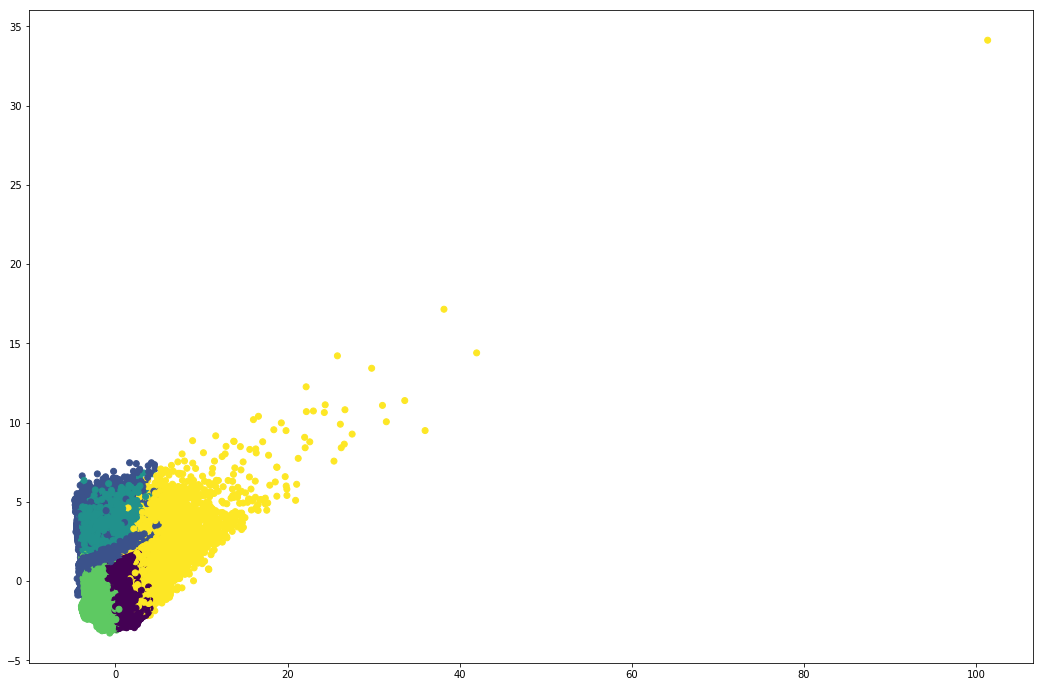

In [41]:
%%time
#Для 63%, где 1 покупка
kmeans = KMeans(n_clusters= 5, random_state=1,n_jobs=-1).fit(X)
labels = kmeans.predict(X)
df_2['labels']=pd.DataFrame(labels)

targert2 = pd.DataFrame(targert2,columns=('X','Y'))
targert2['L'] = pd.DataFrame(labels)

fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12

plt.scatter(targert2['X'], targert2['Y'],c =labels)

In [42]:
print(df_2.shape[0])
print(df_2[df_2['labels']==0].shape[0],df_2[df_2['labels']==0].shape[0]/df_2.shape[0])
print(df_2[df_2['labels']==1].shape[0],df_2[df_2['labels']==1].shape[0]/df_2.shape[0])
print(df_2[df_2['labels']==2].shape[0],df_2[df_2['labels']==2].shape[0]/df_2.shape[0])
print(df_2[df_2['labels']==3].shape[0],df_2[df_2['labels']==3].shape[0]/df_2.shape[0])
print(df_2[df_2['labels']==4].shape[0],df_2[df_2['labels']==4].shape[0]/df_2.shape[0])

930199
373053 0.4010464427504222
35518 0.038183227459930615
162892 0.17511521728146343
254818 0.2739392323578073
103918 0.11171588015037642


In [9]:
pd.concat([df_2[df_2['labels']==0].describe().T['mean'], \
           df_2[df_2['labels']==1].describe().T['mean'], \
           df_2[df_2['labels']==2].describe().T['mean'], \
           df_2[df_2['labels']==3].describe().T['mean'], \
           df_2[df_2['labels']==4].describe().T['mean'], \
           ],axis=1).to_csv('2-cl.csv')

In [51]:
# у нас в описании 1-й кластер 4%, 2-й 40%, 3-й 27%, 4-й 18% и 5-й 11%
label_map = {0: '2.2',
             1: '2.1',
             2: '2.4',
             3: '2.3',
             4: '2.5'}
df_2['labels'] = df_2['labels'].map(label_map) 
df_2[['PartnerID','labels']].to_csv('Segment 2, 5kl.csv')

In [52]:
pd.concat([df[['PartnerID','labels']],df_1[['PartnerID','labels']],df_2[['PartnerID','labels']]],axis=0).to_csv('Clasters.csv')